<a href="https://colab.research.google.com/github/amarabuco/codrift19_project/blob/main/code_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [460]:
!pip install pmdarima

In [461]:
import json
import math
import calendar
from datetime import timedelta as delta
from datetime import datetime as dt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

#models
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as tsa
import statsmodels.stats as sm_stats
from statsmodels.tsa.api import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tools.eval_measures import rmse
#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

#from pmdarima.arima import auto_arima, ARIMA
from pmdarima.arima import auto_arima
import pmdarima.arima

In [462]:
#cases
source = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', parse_dates=True)
#deaths
source2 = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv', parse_dates=True)

### STEP 1: Data collection,Import required libraries and modules, Read data into dataframe, convert data into date–time format.

In [463]:
countries = source2.loc[source2['Province/State'].isna()]
df = pd.DataFrame(countries.T[4:-1])
df.columns = countries['Country/Region']

In [464]:
df = df.asfreq('d')

In [465]:
#df = df.rename({'US': 'Actual_data'}, axis=1)
df = df.rename({'Brazil': 'Actual_data'}, axis=1)

In [466]:
start = dt(year=2020, month=1, day=22)
#start = df['Actual_data'].loc[df['Actual_data'] == 1].index[0]
end = dt(year=2021, month=3, day=30)
#end = dt(year=2020, month=7, day=24) #article training end date
#end = dt(year=2020, month=8, day=3) #article last date known
total_days = (end - start).days
df = df[:total_days+1]
#df.index = pd.date_range(start=start, end=end)

In [467]:
df.tail(1)['Actual_data']

2021-03-30    317646
Freq: D, Name: Actual_data, dtype: object

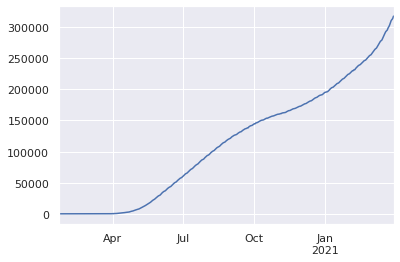

In [468]:
df['Actual_data'].plot()

In [469]:
"""
raw_excel_data = pd.read_excel("US_Data.xlsx")
df_complex=raw_excel_data.copy()
df_complex.date = pd.to_datetime(df_complex.Date, dayfirst = True)
df_complex.set_index("Date", inplace=True)
df= df_complex.asfreq(’d’)
df = df.rename(columns=’USA’: ’Actual_data’})
"""

'\nraw_excel_data = pd.read_excel("US_Data.xlsx")\ndf_complex=raw_excel_data.copy()\ndf_complex.date = pd.to_datetime(df_complex.Date, dayfirst = True)\ndf_complex.set_index("Date", inplace=True)\ndf= df_complex.asfreq(’d’)\ndf = df.rename(columns=’USA’: ’Actual_data’})\n'

### STEP 2: Identify the data trends and seasonality, do differencing to introduce stationarity (identify ‘d’ in ARIMA parameters
(p,d,q))

In [470]:
#seasonality = seasonal_decompose(df["Actual_data"], model='multiplicative')
df["d1"] = diff(df["Actual_data"],k_diff = 1)
df["d2"] = diff(df["Actual_data"],k_diff = 2)

### Step 3: Check the ACF and PACF plots of the actual data and compare them with differenced data

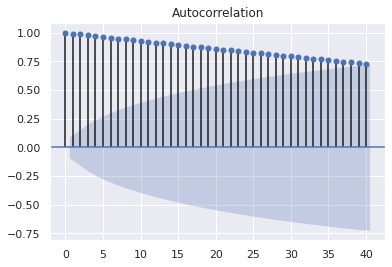

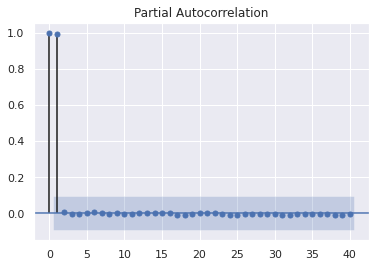

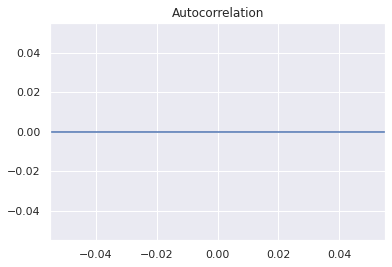

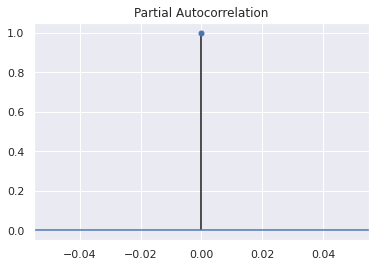

In [471]:
plot_acf(df["Actual_data"], lags = 40, label = "90");
plot_pacf(df["Actual_data"], lags = 40, label = "90");
plot_acf(df['d1'], lags = 40);
plot_pacf(df['d1'], lags = 40);

### Step 4: Split data into test and training data and build the basic model using auto_Arima

In [480]:
size = int(len(df)*0.8)
train_data= df.iloc[:size]
test_data =df.iloc[size:]
len(test_data)
# ARIMA
"""
step_fit = auto_arima(train_data['Actual_data'], start_p=0, start_q=0,
max_p=7, max_q=7,
seasonal=False,# for SARIMA models seasonality is set to True
d=None, trace=True,enforce_stationarity =False,enforce_invertibility = False,
error_action='ignore', information_criterion='aic',
suppress_warnings=True, maxiter = 50,
stepwise=True)
"""
# SARIMA
step_fit = auto_arima(train_data['Actual_data'], start_p=0, start_q=0,
max_p=6, max_q=6, m=7, max_P=7, max_Q=7,
seasonal=True,# for SARIMA models seasonality is set to True
d=None, trace=True,enforce_stationarity =False,enforce_invertibility = False,
error_action='ignore',
suppress_warnings=True,maxiter = 50,
stepwise=True)

step_fit.summary()
get_ipython().run_cell_magic('time', '', 'model_base = ARIMA(train_data["Actual_data"].astype(float), order =(0,2,0))\nresults_base = model_base.fit()\nresults_base.summary()')
#get_ipython().run_cell_magic('time', '', 'model_base = ARIMA(train_data["Actual_data"].astype(float), order =(0,2,0))\nresults_base = model_base.fit()\nresults_base.summary()')
#model_base = ARIMA(order = step_fit.order)
#results_base = model_base.fit(train_data["Actual_data"].astype(float))
#results_base.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=4755.078, Time=0.41 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=4891.134, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=4739.007, Time=0.18 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=4705.271, Time=0.24 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=4797.985, Time=0.09 sec
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=4541.896, Time=0.90 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=4611.839, Time=0.37 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=4543.175, Time=1.42 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=4543.247, Time=0.95 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=4648.272, Time=0.58 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=4558.661, Time=0.69 sec
 ARIMA(0,2,1)(2,0,2)[7]             : AIC=4545.030, Time=2.04 sec
 ARIMA(1,2,1)(1,0,1)[7]             : AIC=4539.733, Time=0.83 sec
 ARIMA(1,2,1)(0,0,1)[7]             : AIC=4701.049, Time=0.45 sec
 ARIMA(1,2,1)(1,0,0)[7]          

In [481]:
step_fit.aic()

4531.915863116974

In [482]:
step_fit.bic()

4554.977129619162

In [483]:
step_fit.order

(1, 2, 2)

In [484]:
test_data

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Actual_data,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Central African Republic,Chad,Chile,Colombia,Comoros,Congo (Brazzaville),Congo (Kinshasa),Costa Rica,Cote d'Ivoire,...,Sierra Leone,Singapore,Slovakia,Slovenia,Solomon Islands,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tajikistan,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe,d1,d2
2021-01-03,2191,1193,2772,84,408,5,43482,2850,6324,2733,175,352,7626,7,1451,19701,250,44,0,9201,4131,42,196018,3,7678,86,2728,2,113,0,448,63,104,16767,43965,13,108,596,2185,138,...,76,29,2317,2803,0,130,29577,63,50837,211,1468,123,8727,7747,729,7,90,21,65,0,68,127,4800,21488,357997,274,19630,679,75024,204,614,0,1034,35,1470,610,394,380,293,-21
2021-01-04,2237,1199,2777,84,408,5,43634,2864,6357,2761,175,352,7650,7,1461,19750,257,44,0,9219,4131,45,196561,3,7835,86,2744,2,113,0,448,63,104,16767,44187,13,108,599,2229,138,...,76,29,2521,2838,0,130,30011,63,51078,215,1468,124,8727,7918,734,7,90,21,65,0,69,127,4862,21685,360095,274,19712,682,75431,211,614,0,1038,35,1490,610,398,384,543,250
2021-01-05,2244,1210,2782,84,410,5,43785,2878,6457,2792,175,352,7670,7,1471,19827,258,44,0,9241,4211,45,197732,3,7902,86,2766,2,113,0,448,63,105,16788,44428,13,108,599,2248,138,...,76,29,2603,2868,0,130,30524,63,51430,217,1468,125,8965,8018,741,7,90,21,66,0,69,127,4934,21879,363786,290,19929,685,76305,217,614,0,1042,35,1505,610,412,418,1171,628
2021-01-06,2244,1217,2786,84,413,5,43976,2890,6525,2818,175,353,7687,7,1480,19883,260,44,0,9287,4211,45,198974,3,7961,89,2785,2,113,0,448,63,105,16816,44723,13,108,599,2267,138,...,76,29,2657,2899,0,130,31368,63,51430,219,1468,126,8965,8109,747,7,90,21,67,0,70,127,5004,22070,367715,294,20171,689,77346,221,615,0,1047,35,1519,610,417,431,1242,71
2021-01-07,2253,1223,2792,84,413,5,44122,2901,6568,2845,175,353,7718,7,1489,19936,267,44,0,9304,4211,48,200498,3,8017,89,2799,2,113,0,448,63,105,16913,45067,16,108,610,2286,138,...,77,29,2717,2922,0,130,31809,63,51675,222,1468,130,9262,8178,755,7,90,21,67,0,72,127,5052,22264,371681,297,20334,694,78508,231,615,0,1052,35,1536,610,423,446,1524,282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-26,2467,2192,3074,114,532,28,55235,3434,9200,3445,188,512,8830,41,2202,22852,317,90,1,12143,6220,506,307112,3,12601,145,3205,6,165,8,721,64,158,22587,62645,146,135,726,2931,229,...,79,30,9373,4008,0,471,52602,108,75010,557,2028,177,13402,10298,1216,10,90,21,92,0,107,141,8684,30772,548172,335,33068,1472,126515,875,624,0,1543,35,2537,820,1194,1518,3650,873
2021-03-27,2469,2204,3077,115,533,28,55368,3450,9231,3464,188,513,8869,41,2211,22870,317,90,1,12165,6220,506,310550,3,12650,145,3206,6,165,8,721,64,160,22653,62790,146,135,734,2931,232,...,79,30,9426,4011,0,488,52648,108,75010,558,2028,177,13402,10299,1227,10,90,21,93,0,107,142,8705,30923,548913,335,33363,1477,126573,901,625,0,1555,35,2557,832,1198,1519,3438,-212
2021-03-28,2470,2210,3080,115,533,28,55449,3464,9256,3491,188,513,8904,41,2219,22897,317,90,1,12186,6220,506,312206,3,12710,145,3206,6,165,10,721,64,162,22754,62955,146,135,739,2931,237,...,79,30,9496,4018,0,496,52663,108,75010,561,2028,177,13402,10300,1239,10,90,21,94,0,107,142,8735,31076,549420,335,33571,1481,126592,915,626,0,1565,35,2581,851,1200,1520,1656,-1782
2021-03-29,2472,2216,3084,115,

### Step 5: Predict the test data using the basic model parameters and plot actual data vs predictions based on the basic model

predicted=196039.9101, expected=196018
predicted=196355.7304, expected=196561
predicted=196672.4609, expected=197732
predicted=196990.1014, expected=198974
predicted=197308.6522, expected=200498
predicted=197628.113 , expected=201460
predicted=197948.4841, expected=202631
predicted=198269.7652, expected=203100
predicted=198591.9565, expected=203580
predicted=198915.058 , expected=204690
predicted=199239.0696, expected=205964
predicted=199563.9913, expected=207095
predicted=199889.8232, expected=208246
predicted=200216.5652, expected=209296
predicted=200544.2174, expected=209847
predicted=200872.7797, expected=210299
predicted=201202.2522, expected=211491
predicted=201532.6348, expected=212831
predicted=201863.9275, expected=214147
predicted=202196.1304, expected=215243
predicted=202529.2435, expected=216445
predicted=202863.2667, expected=217037
predicted=203198.2   , expected=217664
predicted=203534.0435, expected=218878
predicted=203870.7971, expected=220161
predicted=204208.4609, ex

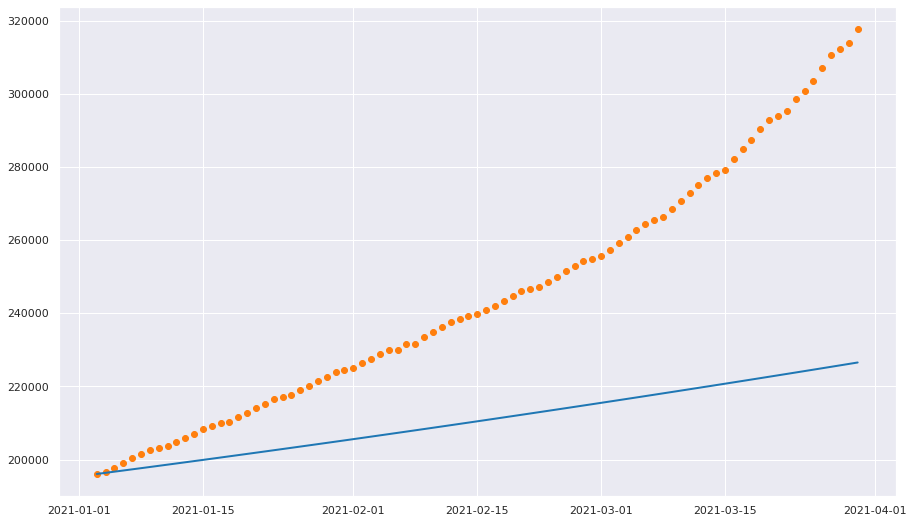

In [485]:
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions_base = results_base.predict(start=start, end=end, dynamic=False, typ='levels').rename('BASE_model Predictions')
#predictions_base = results_base.predict_in_sample(start=start, end=end, dynamic=False, typ='levels')
for i in range(len(predictions_base)):
  print(f"predicted={predictions_base[i]:<11.10}, expected={test_data['Actual_data'][i]}")
plt.rc('axes', axisbelow=True)
fig = plt.figure(figsize = (15,9))
Test_data, = plt.plot(test_data['Actual_data'],"o",color = "#ff7f0e", label = "Test data (USA)")
predicted, = plt.plot(pd.Series(predictions_base, index=test_data.index), color = '#1f77b4', label = 'Predictions(Basic model)', linewidth=2)

### Step 6: Evaluation of the Basic model

In [486]:
error_1 = mean_squared_error(test_data['Actual_data'], predictions_base)
error_2 = mean_absolute_error(test_data['Actual_data'], predictions_base)
error_3 = rmse(test_data['Actual_data'], predictions_base)

### Step 7: Development of the basic model based on the ACF and PACF plots of the residuals

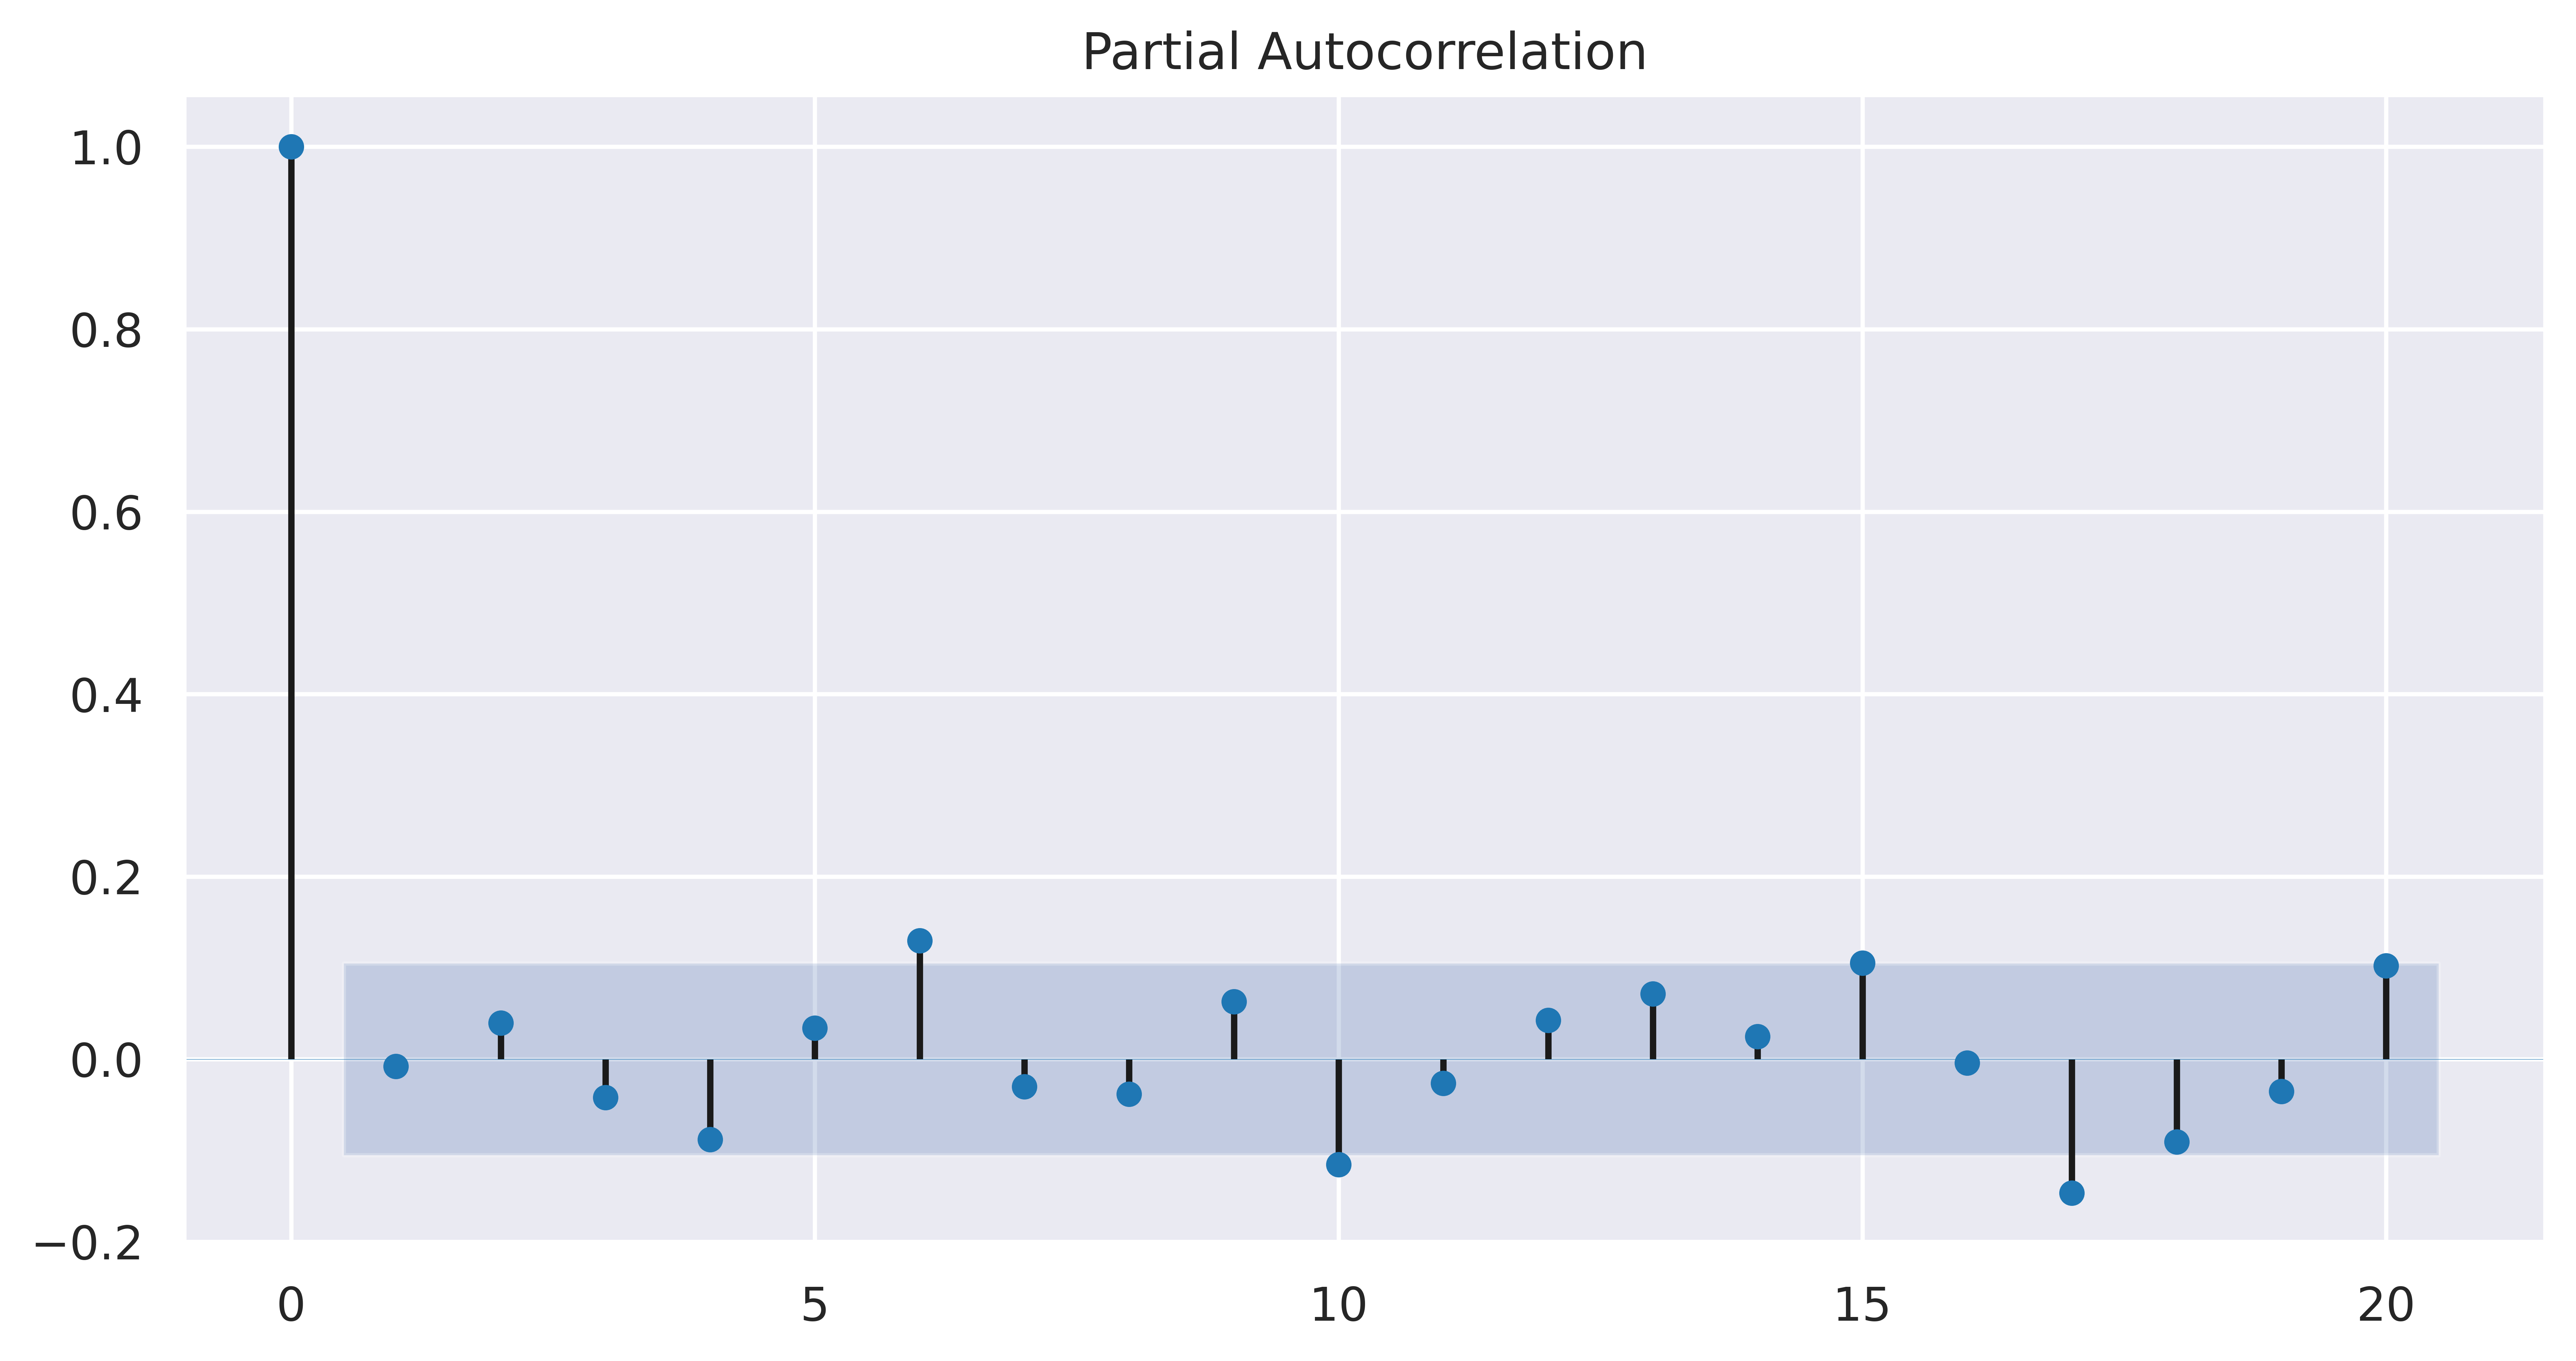

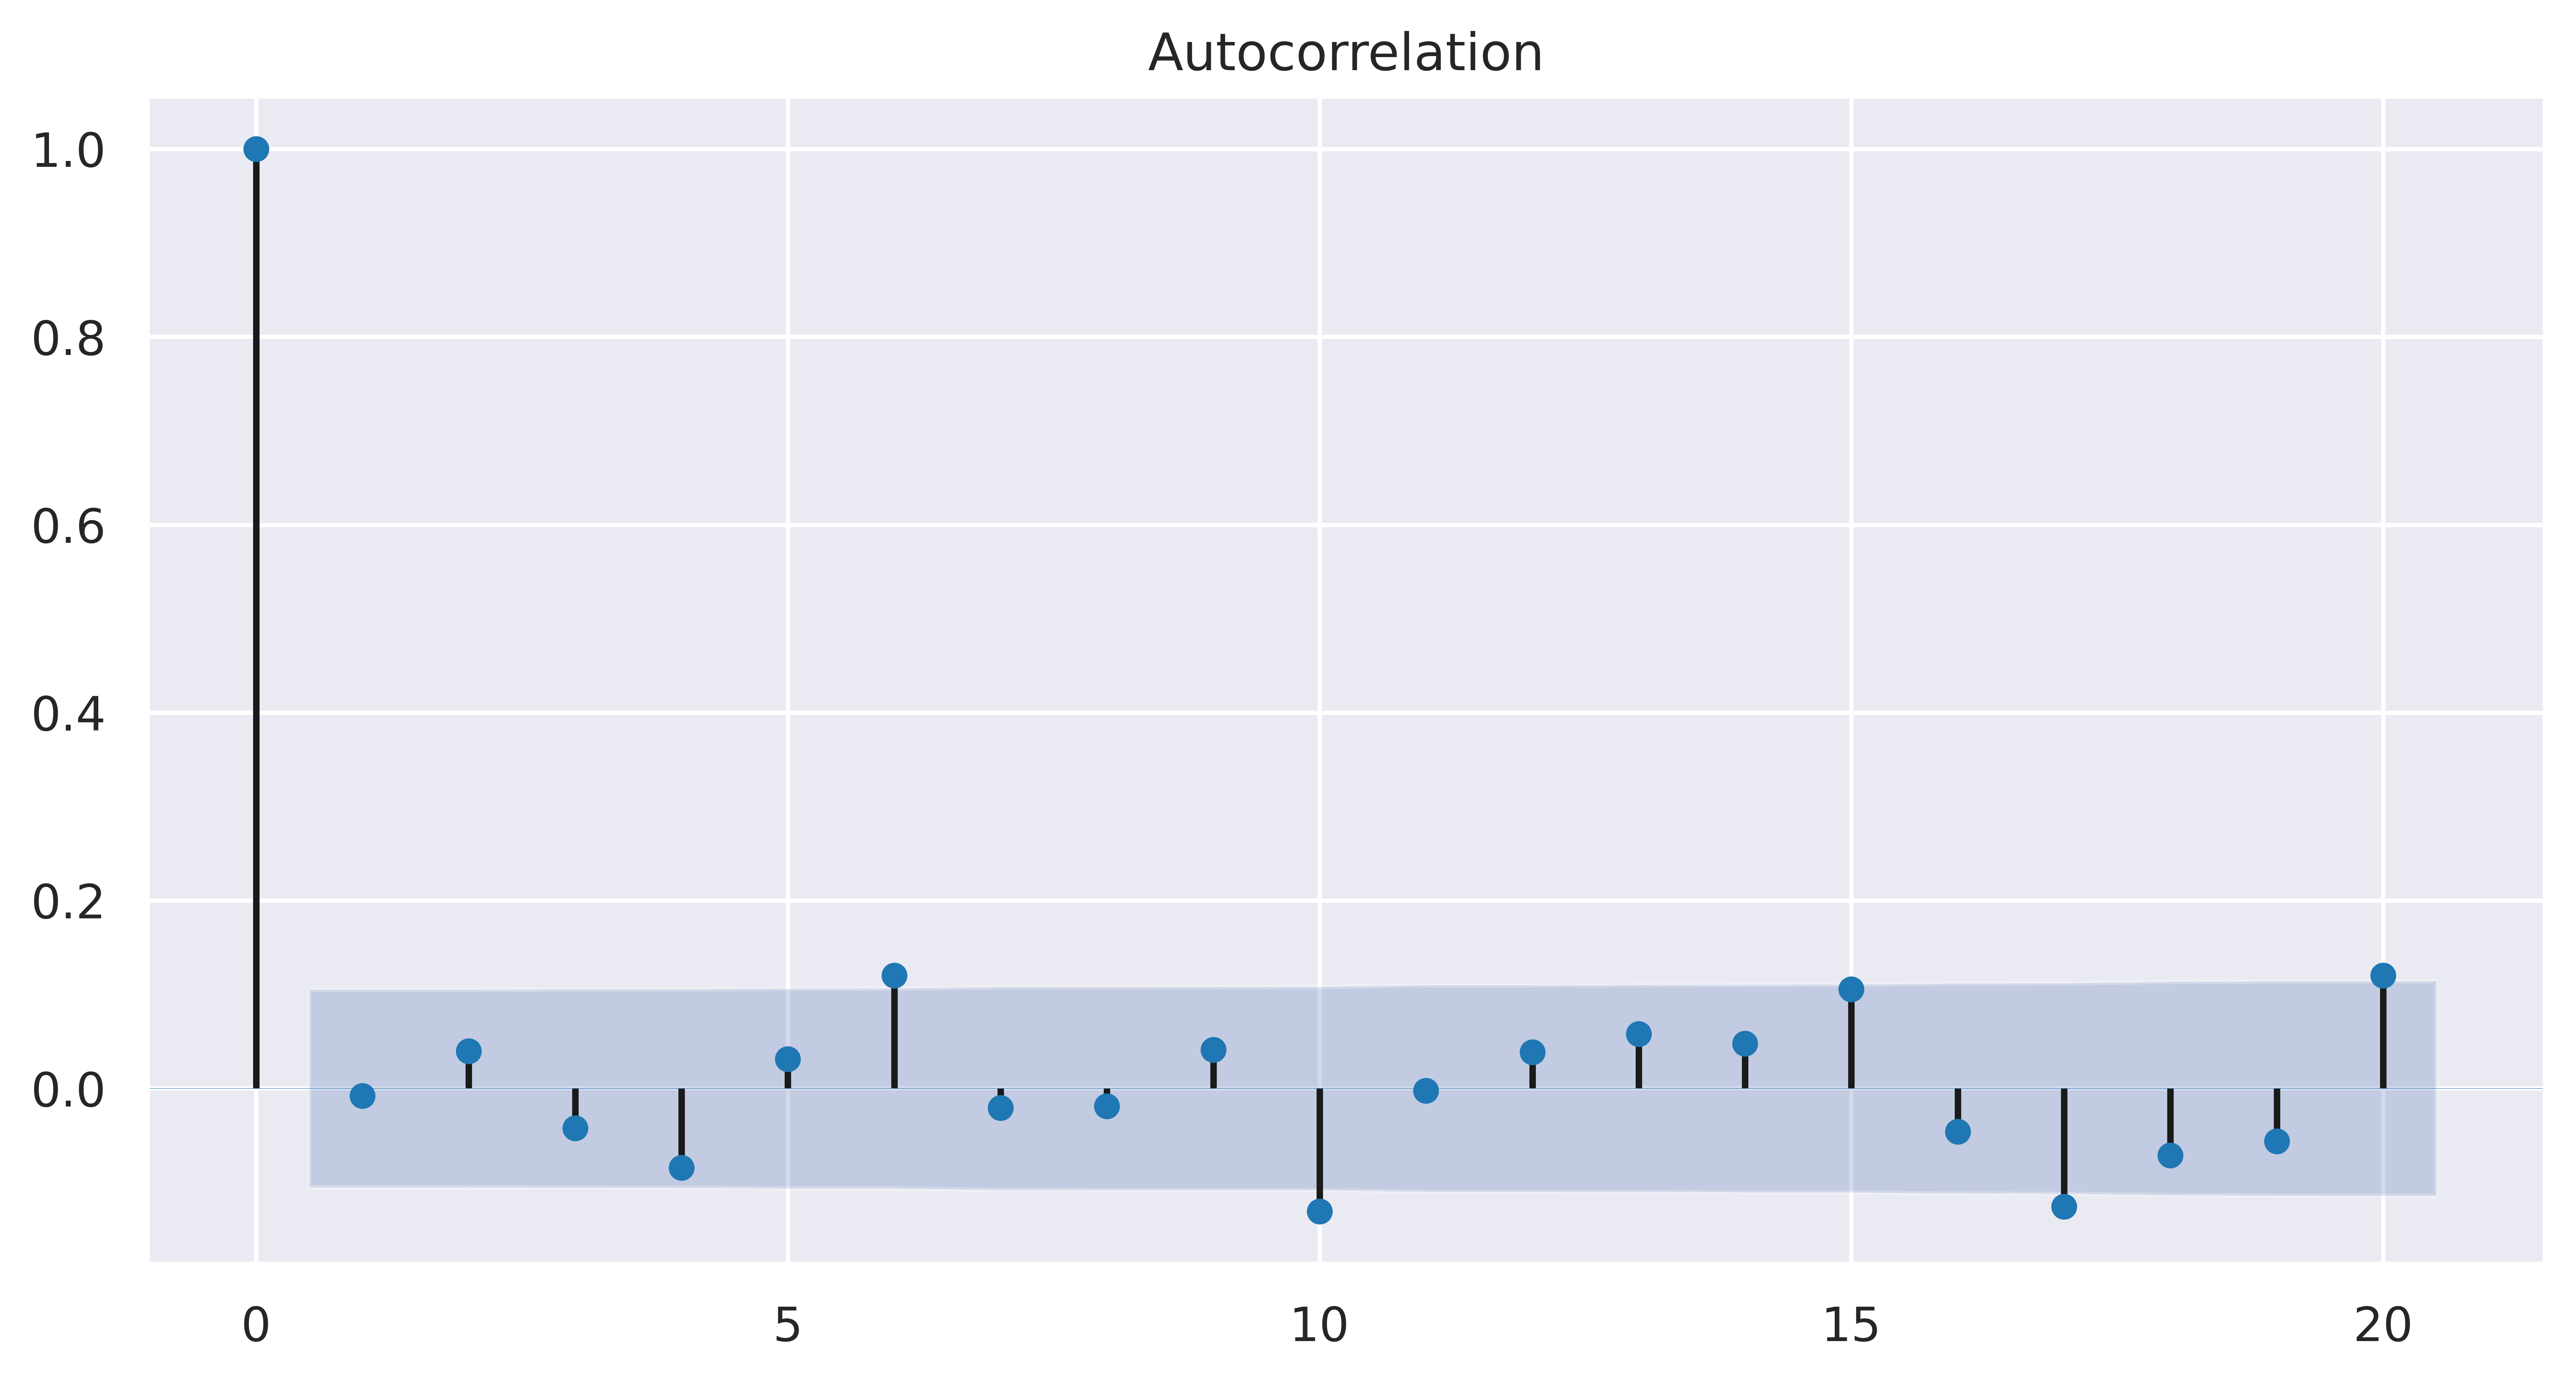

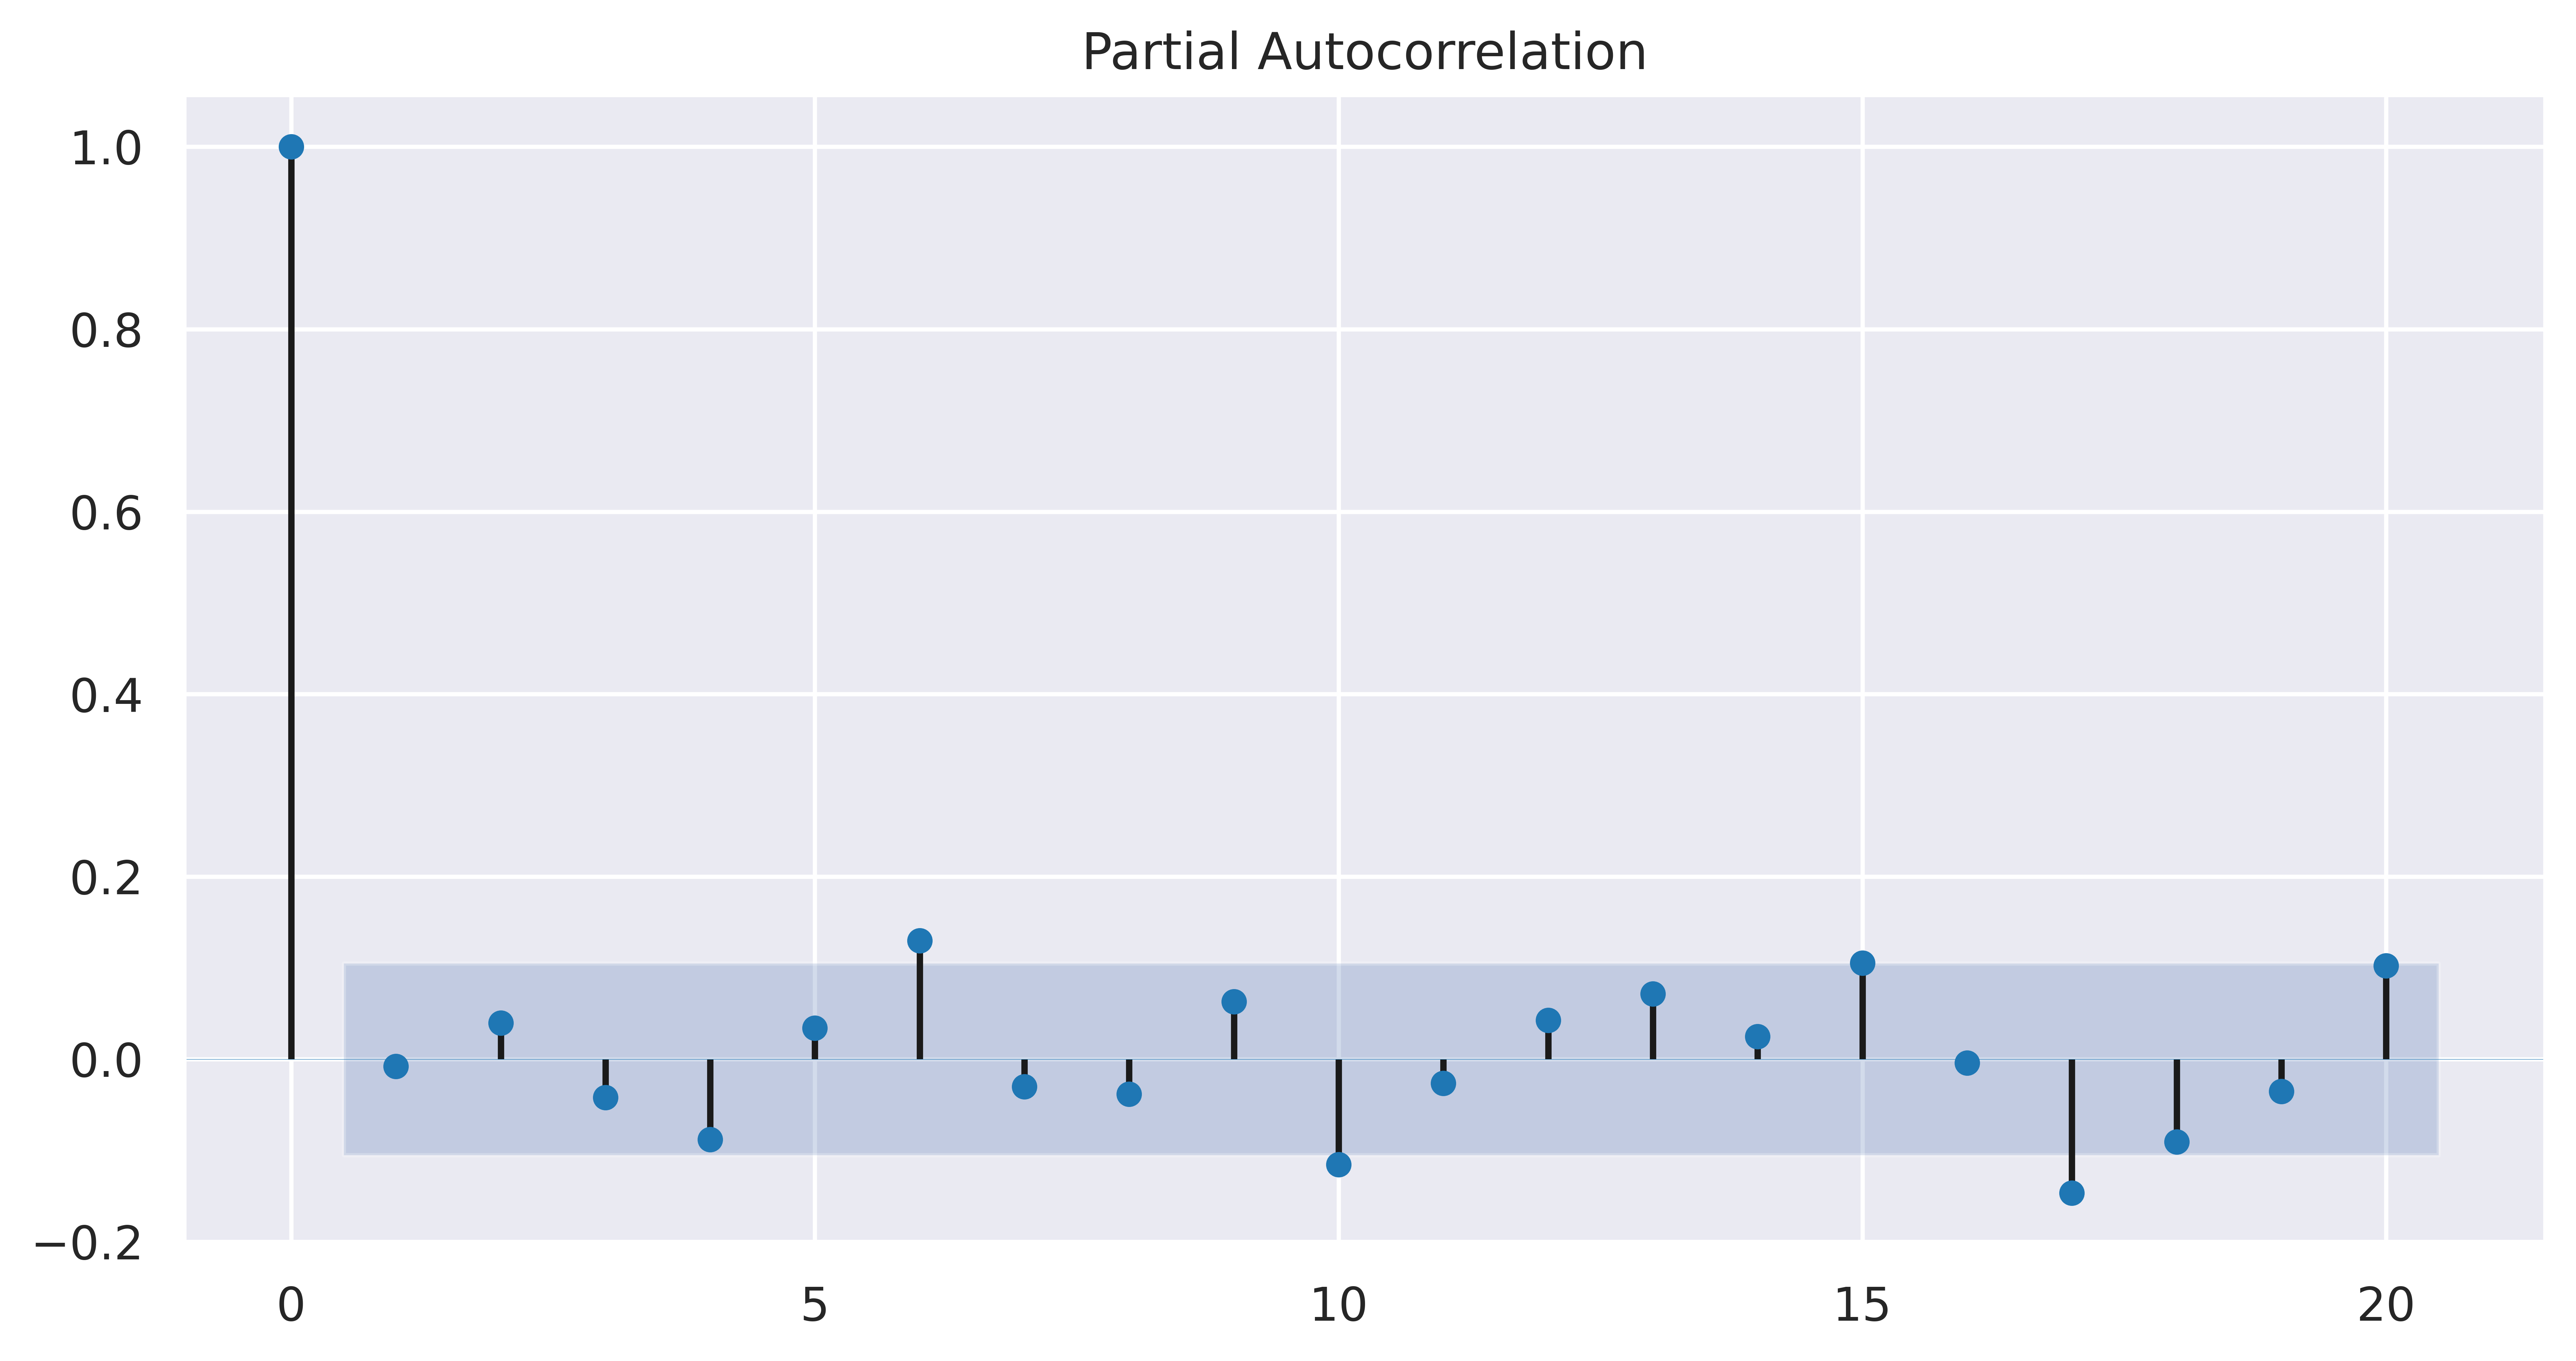

In [488]:
# ARIMA
model = ARIMA(train_data['Actual_data'].astype(float), order=step_fit.order)
# SARIMA
model = SARIMAX(train_data['Actual_data'].astype(float), order=step_fit.order, seasonal_order=step_fit.seasonal_order)
results = model.fit(start_ar_lags = 8)
fcast=results.predict(len(train_data),len(train_data)+len(test_data),typ='levels')
#fcast=results.predict(len(df),len(df)+60,typ='levels')
fig, ax = plt.subplots(figsize=(10, 5),dpi=900)
plot_acf(results.resid, lags =20,ax=ax,color ='#1f77b4',linewidth =0.1)
fig, ax = plt.subplots(figsize=(10, 5),dpi=900)
plot_pacf(results.resid, lags =20,ax=ax,color='#1f77b4',linewidth =0.1)

### Step 8: Plot predictions based on developed model and actual data.

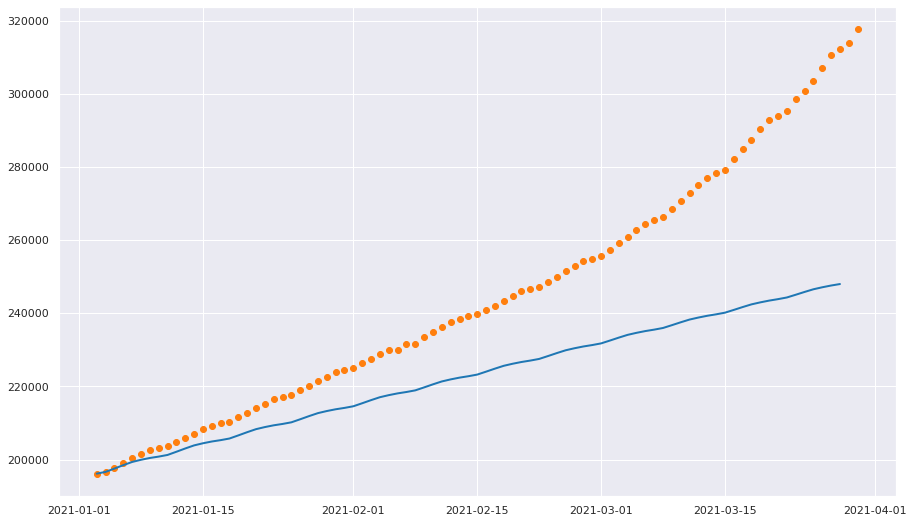

In [490]:
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions = results.predict(start=(start-2), end=(end-2), dynamic=False, typ='levels')
plt.rc('axes', axisbelow=True)
fig = plt.figure(figsize = (15,9))
Test_data, = plt.plot(test_data['Actual_data'],"o",color = "#ff7f0e", label = "Test data (USA)")
predicted, =plt.plot(pd.Series(predictions, index=test_data.index), color = '#1f77b4', label = 'Predictions', linewidth =2)

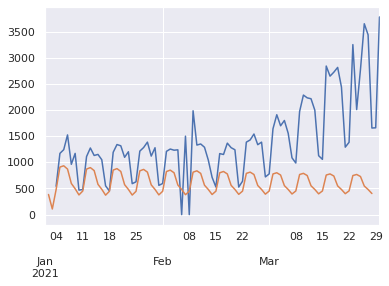

In [491]:
test_data['Actual_data'].diff().plot()
predictions.diff().plot()

In [492]:
df['Actual_data'].tail()

2021-03-26    307112
2021-03-27    310550
2021-03-28    312206
2021-03-29    313866
2021-03-30    317646
Freq: D, Name: Actual_data, dtype: object

### Step 9: Evaluation metrics for developed model

In [493]:
MSE = mean_squared_error(test_data['Actual_data'], predictions)
MAE = mean_absolute_error(test_data['Actual_data'], predictions)
RMSE = rmse(test_data['Actual_data'], predictions)
print(MSE)
print(RMSE)
print(MAE)

849506038.314625
29146.286870107913
22864.707709717517


In [494]:
MSE

849506038.314625

In [495]:
MAE

22864.707709717517

In [496]:
predictions

2021-01-01    195641.075505
2021-01-02    196025.888899
2021-01-03    196133.231468
2021-01-04    196612.217174
2021-01-05    197521.320066
                  ...      
2021-03-24    245822.701998
2021-03-25    246551.294255
2021-03-26    247097.756458
2021-03-27    247578.599420
2021-03-28    247981.667797
Freq: D, Name: predicted_mean, Length: 87, dtype: float64

### Step 10: Diagnosing the developed model with kde/q–q plots

0    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

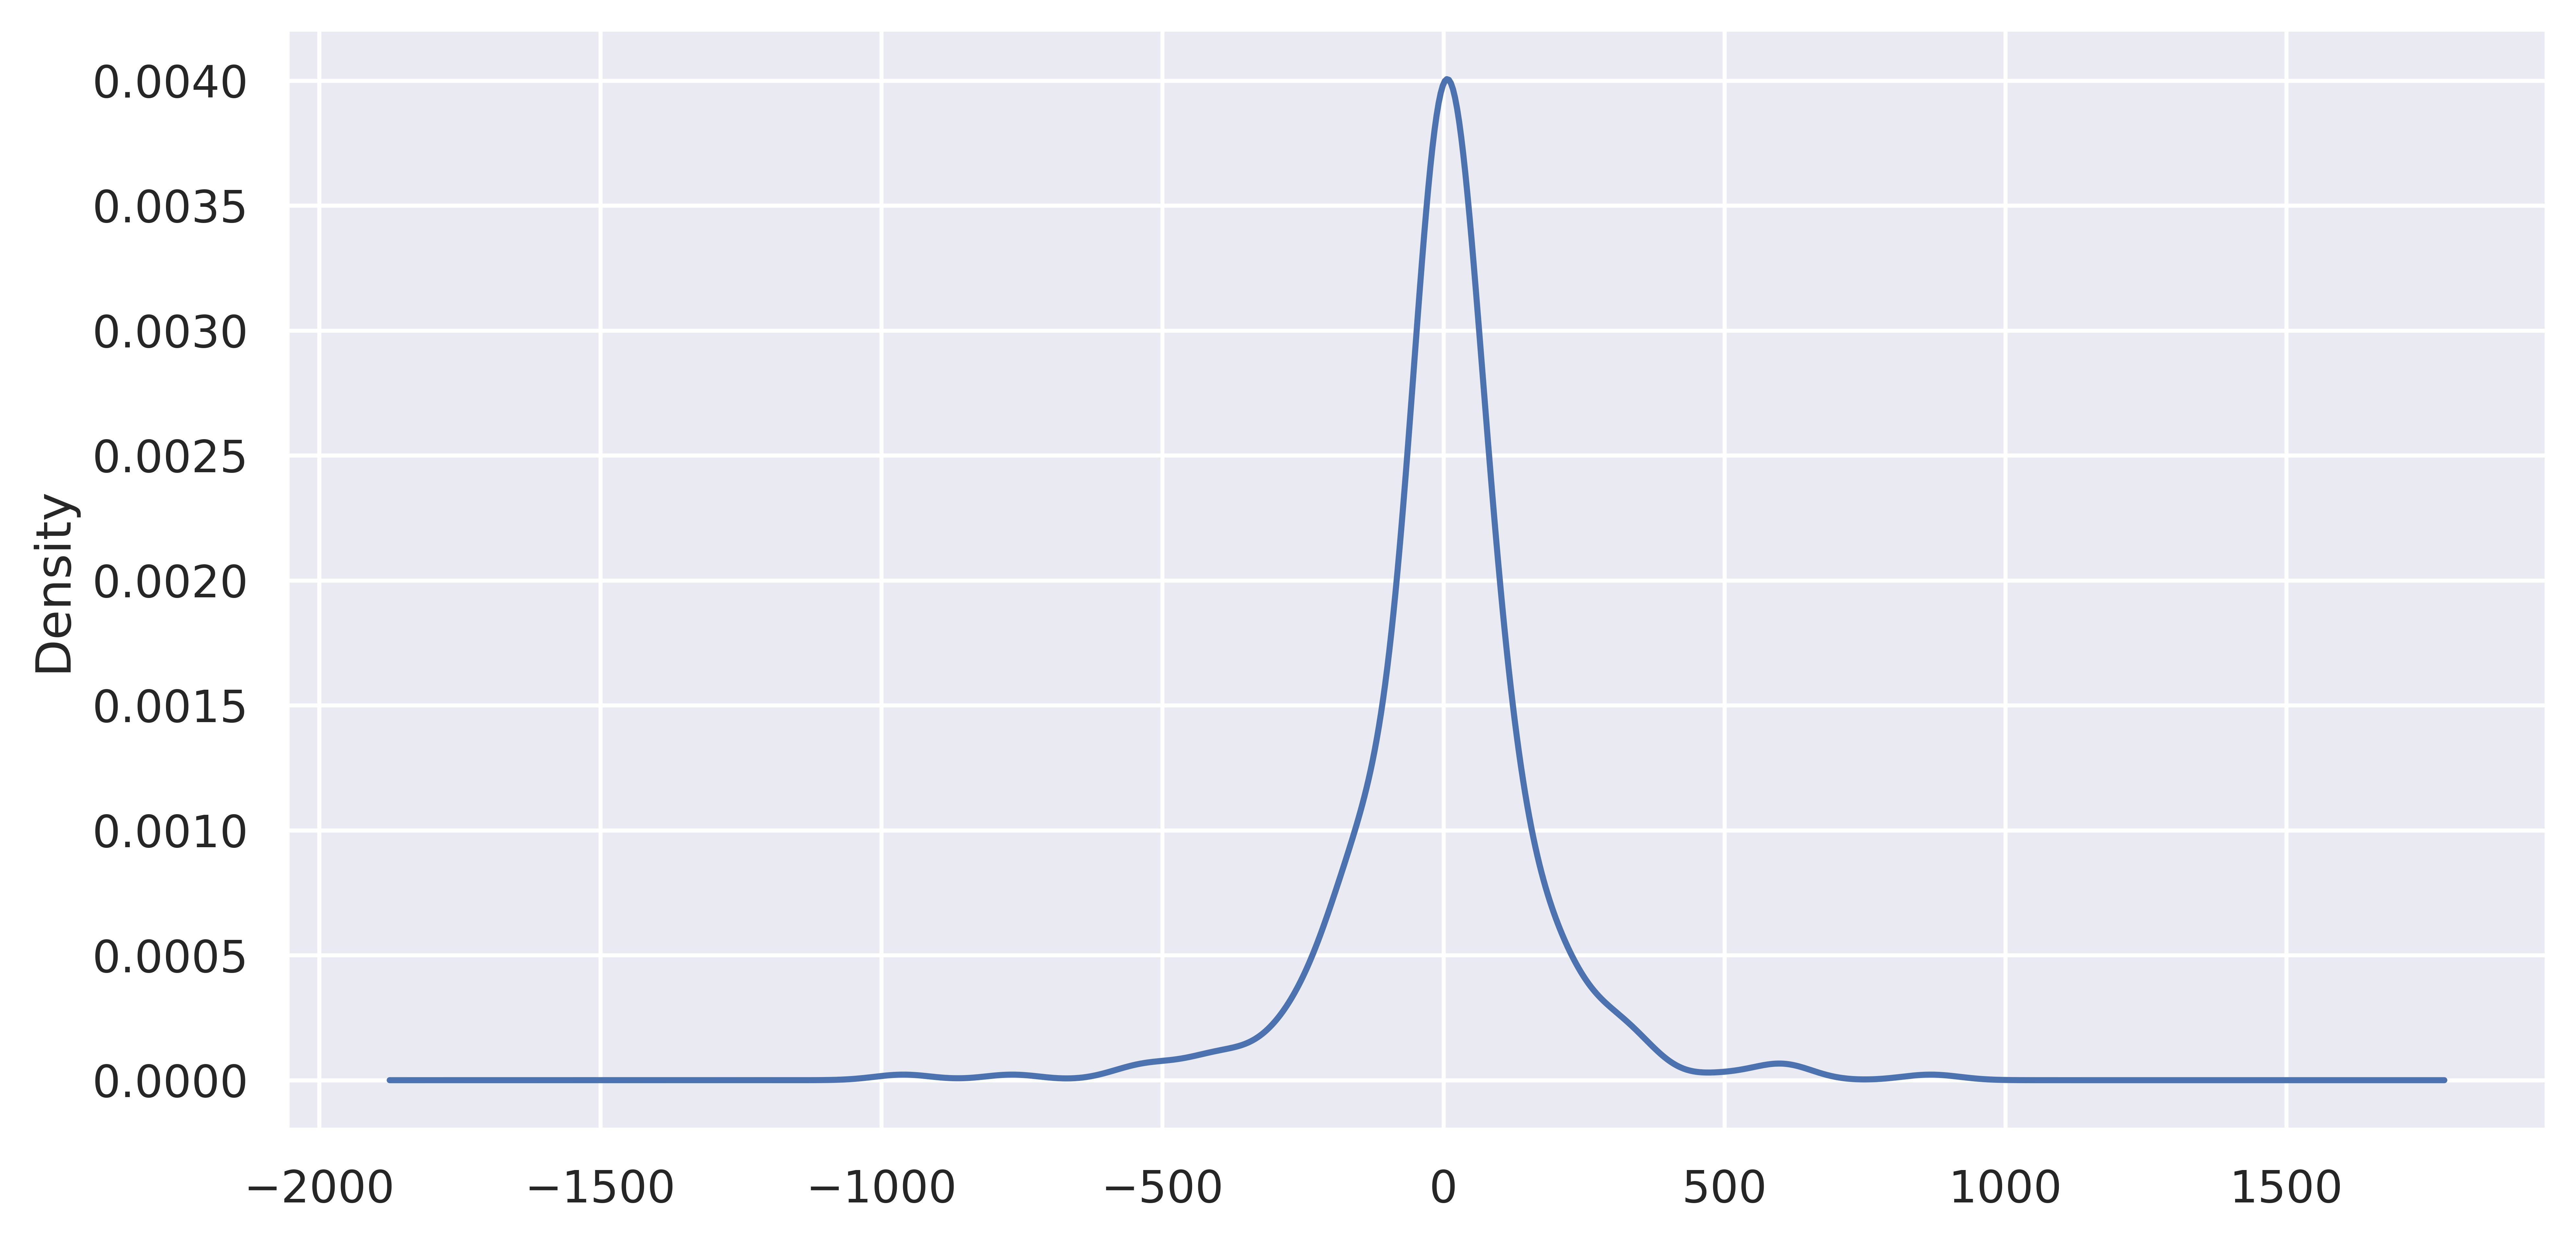

In [497]:
fig, ax = plt.subplots(figsize=(10,5), dpi=900)
pd.Series(results.resid.plot(kind = "kde"))

### Step 11: Forecasting time-series data based on the selected model


In [498]:
#model = ARIMA(df['Actual_data'].astype(float), order=step_fit.order)

AttributeError: ignored

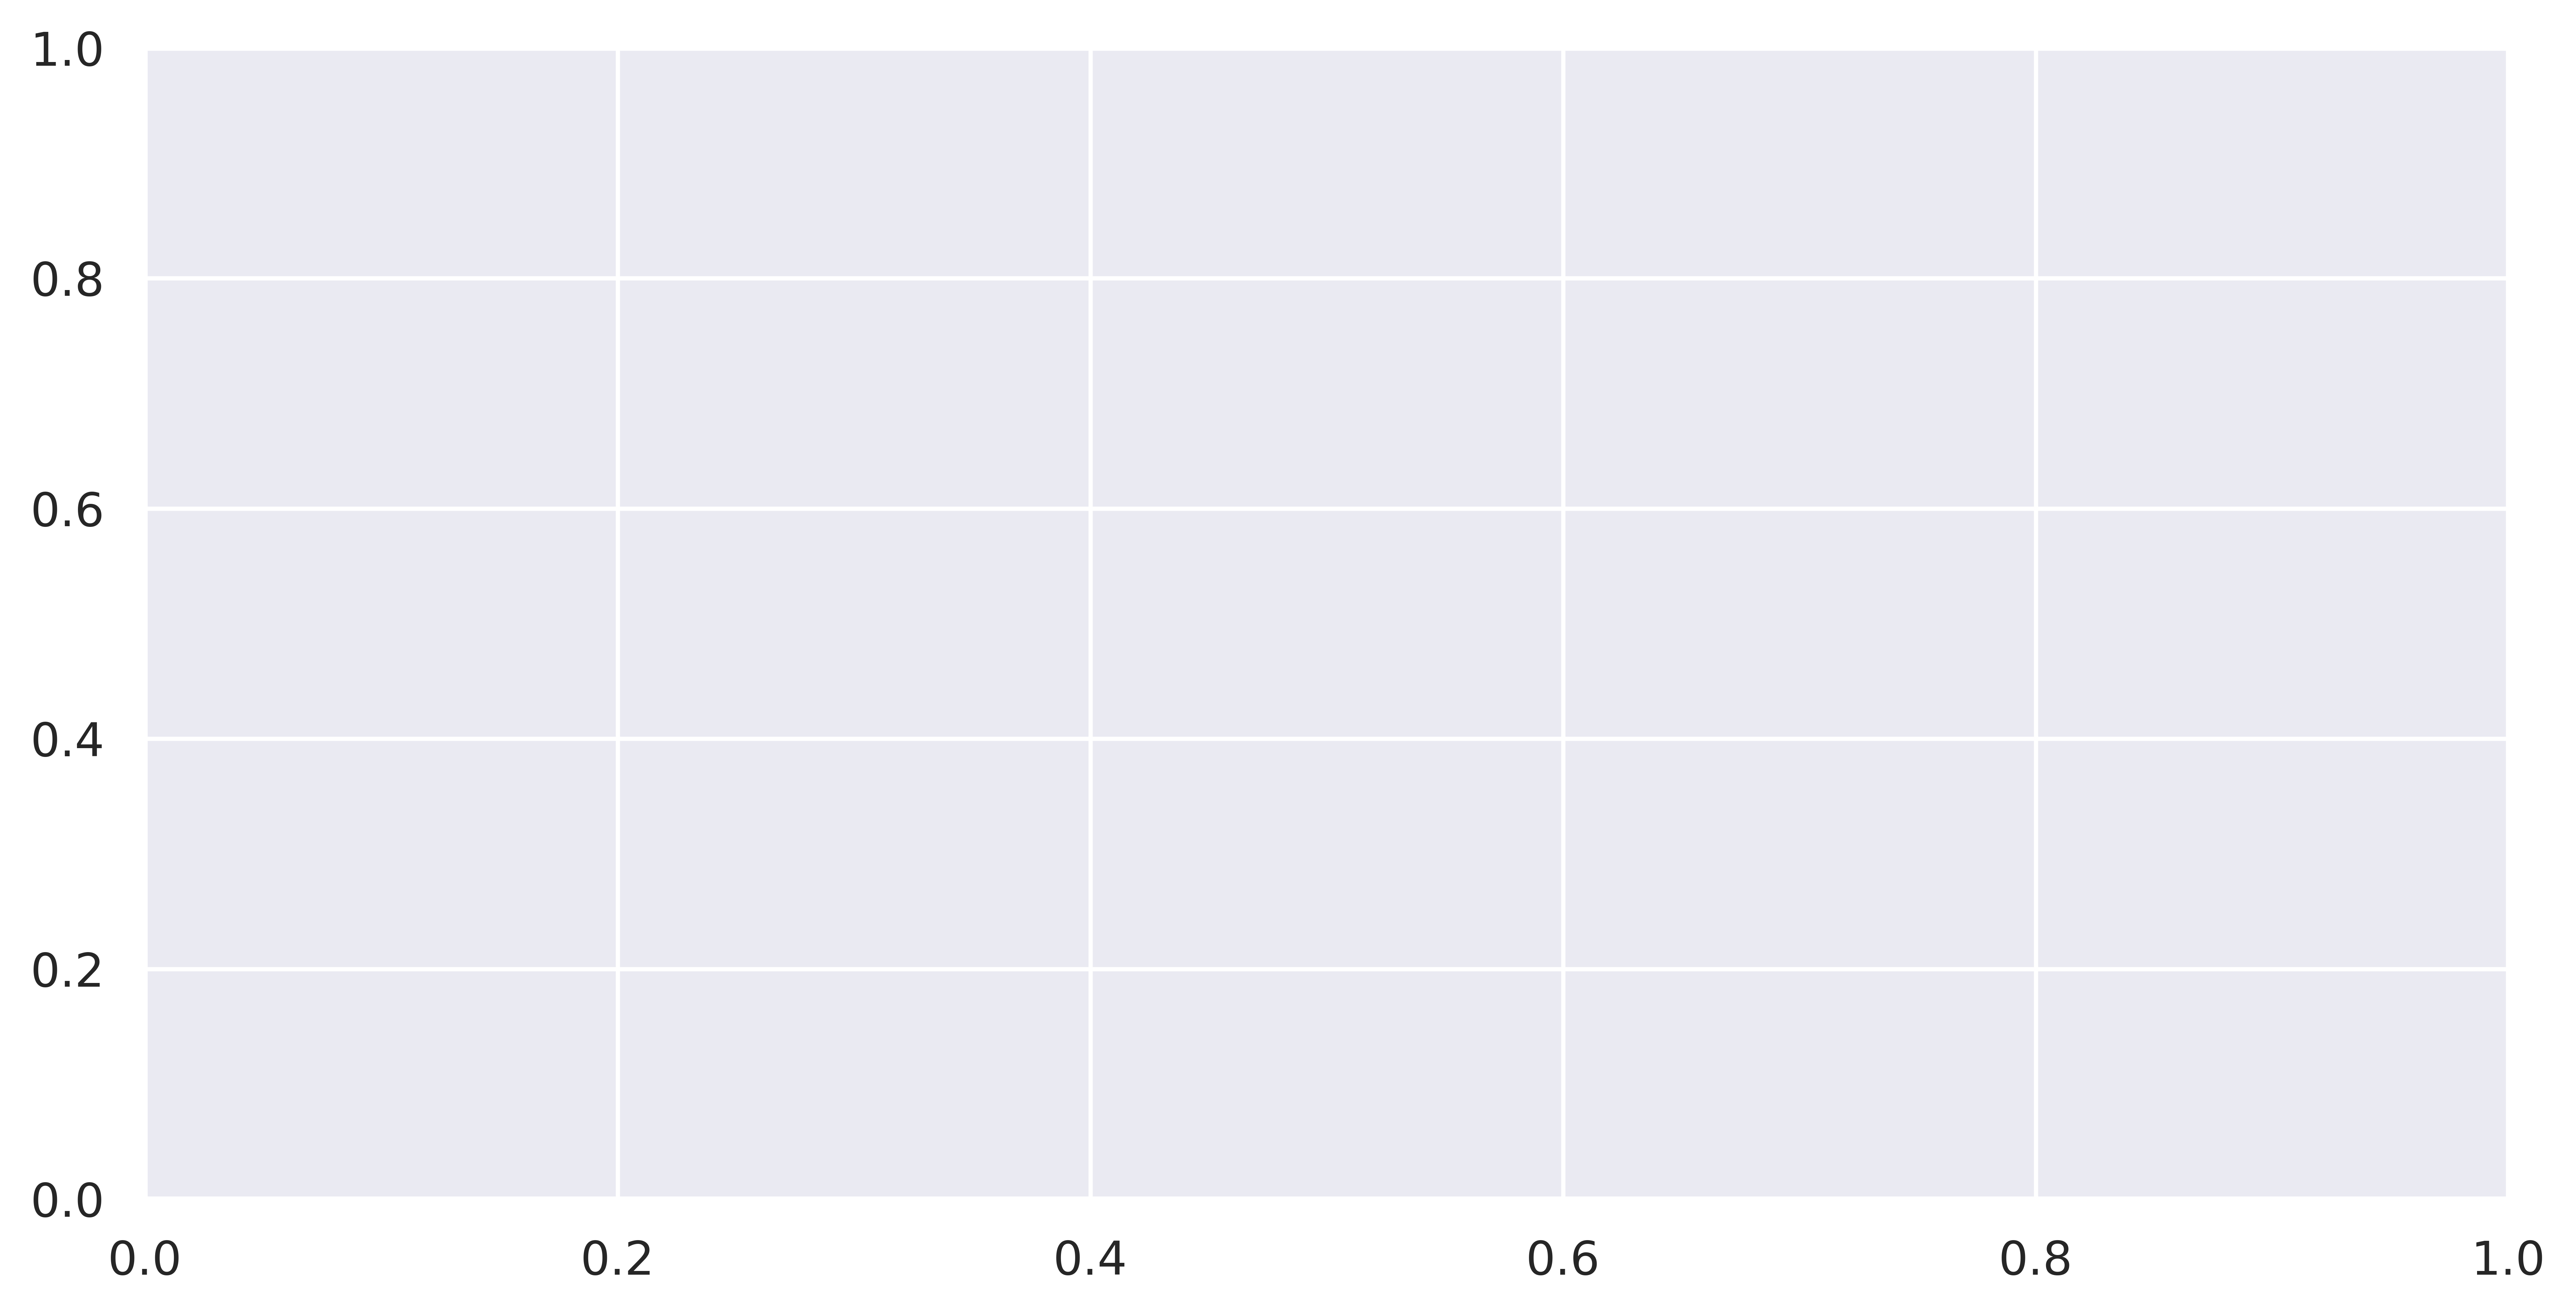

In [499]:
figs, ax = plt.subplots(figsize=(10,5),dpi = 900)
model_fit = model.fit(disp = -1000, start_ar_lags=8)
figs = model_fit.plot_predict(10,235,dynamic = False,plot_insample = True, ax=ax)

In [ ]:
df['Actual_data']

In [503]:
start = dt(year=2020, month=1, day=22)
#start = dt(year=2021, month=3, day=30)
fit_end = dt(year=2021, month=3, day=30)
end = dt(year=2021, month=5, day=29)

#model = ARIMA(df['Actual_data'].astype(float), order=step_fit.order)
model = SARIMAX(df01['Actual_data'].astype(float), order=step_fit.order, seasonal_order=step_fit.seasonal_order)
results = model.fit(start_ar_lags = 8)
#results = model.fit()
fcast=results.predict(len(df['Actual_data']),len(df['Actual_data'])+60,typ='levels')

#model_fit = ARIMA(start=(start), end=(fit_end), dynamic=False, typ='levels')
#predictions = model_fit.predict(start=(fit_end), end=(end), dynamic=False, typ='levels')
fcast

2021-03-31    320493.041385
2021-04-01    323734.642152
2021-04-02    327289.739548
2021-04-03    330643.183356
2021-04-04    332796.626831
                  ...      
2021-05-26    550253.427513
2021-05-27    555734.488436
2021-05-28    561501.848460
2021-05-29    567085.650640
2021-05-30    571678.416103
Freq: D, Name: predicted_mean, Length: 61, dtype: float64